<a href="https://colab.research.google.com/github/cse-teacher/suggestion-mining/blob/main/suggestion_mining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Suggestion Mining
Suggestion mining is the task of extracting suggestions from user reviews

Developed: 11 Feb 2024 \\
Last Update: 11 Feb 2024 \\
Author: Muharram Mansoorizadeh plus Various AI tools (Google search, chatGPT, Gemini , ...)




## Install Required Packagaes

In [2]:
#Install required packages and libraries

!apt-get install libenchant-2-2
!pip install emoji
!pip install cleantext
!pip install nltk
!pip install pyenchant
!pip install scikit-learn lightgbm catboost
!pip install gensim
!pip install transformers sentencepiece sacremoses
!pip install ekphrasis

'apt-get' is not recognized as an internal or external command,
operable program or batch file.


## Import data

Get the required data files from github repository

In [3]:
!git clone https://github.com/cse-teacher/suggestion-mining.git

Cloning into 'suggestion-mining'...


## Prepare data

In [2]:
# Read data from input files
#Reset environment
%reset -f

import numpy as np
import pandas as pd
import random
import sys
#reset stdout
sys.stdout  = sys.__stdout__

#Set default seed:
random.seed(42)

#Main Application
folder     = "./suggestion-mining/data/"
train_file = folder + "V1.4_Training.csv" #"Train_Augmented_03.csv" # V1.4_Training.csv" #  "Train_processed.csv" /suggestion-mining/data/Train_Augmented_03.csv
valid_file = folder + "SubtaskA_Trial_Test_Labeled.csv" #"validation_processed.csv"
test_file  = folder + "SubtaskA_EvaluationData_labeled.csv"


train_df = pd.read_csv(train_file,
                       encoding_errors='ignore', header=None,
                       names=["id", "sentence", "label"])

valid_df = pd.read_csv(valid_file,
                       encoding_errors='ignore', header=None,
                       names=["id", "sentence", "label"])

test_df  = pd.read_csv(test_file,
                       encoding_errors='ignore', header=None,
                       names=["id", "sentence", "label"])

all_df = pd.concat([train_df, valid_df, test_df], axis=0)


#Get the labels:
y_train_original = train_df['label'].values
y_valid_original = valid_df['label'].values
y_test_original  = test_df['label'].values
y_all_original  = all_df['label'].values
train_size = len(train_df['label'])
valid_size = len(valid_df['label'])
test_size  = len(test_df['label'])



**Preprocessing**

In [ ]:
import sys
import re
import nltk
import cleantext
from nltk import word_tokenize, pos_tag, ne_chunk
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

def remove_nonalphanumeric(text):
    #text = re.sub(r'[^A-Za-z0-9]+', ' ', text)
  text = re.sub(r'\W+', ' ', text)
  text = re.sub(r'\s+', ' ', text)
  return text

def remove_stopwords_list(tokens):
  filtered_tokens = [w for w in tokens if not w.lower() in stop_words]
  return filtered_tokens

def remove_stopwords(text):
  tokens = word_tokenize(text)
  filtered_tokens = remove_stopwords_list(tokens)
  return ' '.join(filtered_tokens)

#-----------------------------------
# Replace hyperlinks
#
def replace_hyperlinks(text):
  text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
  return text

def stem(text):
  tokens = word_tokenize(text.strip())
  tokens_stem =[stemmer.stem(s) for s in tokens]
  return ' '.join(tokens_stem)

#----------------------------------------
# replace_named_entities:
#    Replaces each word or phrase in the input text with its
#    Named Entity Recognition (NER) tag label.
#    Args:
#    text (str): Input text
#
#    Returns:
#    str: Text with named entities replaced by their NER tag labels
#
def replace_named_entities(text):
    # Tokenize the text into words
    words = word_tokenize(text)

    # Tag the words with Part-of-Speech (POS) tags
    tagged_words = pos_tag(words)

    # Perform Named Entity Recognition (NER)
    named_entities = ne_chunk(tagged_words)

    # Replace entities with their NER tag labels
    replaced_text = []
    for entity in named_entities:
        if isinstance(entity, nltk.tree.Tree):
            label = entity.label()
            named_entity_text = " ".join([word for word, tag in entity.leaves()])
            #replaced_text.append(f'<{label}>{named_entity_text}</{label}>')
            replaced_text.append(f'{label}')
            #replaced_text.append('')
        else:
            replaced_text.append(entity[0])

    return " ".join(replaced_text)

#Global callings:
stemmer = SnowballStemmer("english")
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Example usage:
text = "Microsoft should seriously look into getting rid of Syamentc for all these paying stuff"
replaced_text = replace_named_entities(text)
print("Replaced Text:", replaced_text)


[nltk_data] Error loading punkt: <urlopen error [WinError 10060] A
[nltk_data]     connection attempt failed because the connected party
[nltk_data]     did not properly respond after a period of time, or
[nltk_data]     established connection failed because connected host
[nltk_data]     has failed to respond>


In [6]:
op_replace_hyperlinks      = True
op_remove_nonalphanumeric  = True
op_remove_stopwords        = False
op_replace_named_entities  = True
op_stem                    = True

if op_replace_hyperlinks == True:
  #replace named entities with their tag names:
  train_df['sentence']  = train_df['sentence'].apply(replace_hyperlinks)
  test_df['sentence']   = test_df['sentence'].apply(replace_hyperlinks)
  valid_df['sentence']  = valid_df['sentence'].apply(replace_hyperlinks)
  all_df['sentence']    = all_df['sentence'].apply(replace_hyperlinks)

if op_remove_nonalphanumeric == True:
  train_df['sentence'] = train_df['sentence'].apply(remove_nonalphanumeric)
  valid_df['sentence'] = valid_df['sentence'].apply(remove_nonalphanumeric)
  test_df['sentence']  = test_df['sentence'].apply(remove_nonalphanumeric)
  all_df['sentence']   = all_df['sentence'].apply(remove_nonalphanumeric)

if op_replace_named_entities == True:
  train_df['sentence']  = train_df['sentence'].apply(replace_named_entities)
  test_df['sentence']   = test_df['sentence'].apply(replace_named_entities)
  valid_df['sentence']  = valid_df['sentence'].apply(replace_named_entities)
  all_df['sentence']    = all_df['sentence'].apply(replace_named_entities)

if op_remove_stopwords == True:
  train_df['sentence'] = train_df['sentence'].apply(remove_stopwords)
  valid_df['sentence'] = valid_df['sentence'].apply(remove_stopwords)
  test_df['sentence']  = test_df['sentence'].apply(remove_stopwords)
  all_df['sentence']   = all_df['sentence'].apply(remove_stopwords)

if op_stem == True:
  train_df['sentence'] = train_df['sentence'].apply(stem)
  valid_df['sentence'] = valid_df['sentence'].apply(stem)
  test_df['sentence']  = test_df['sentence'].apply(stem)
  all_df['sentence']   = all_df['sentence'].apply(stem)


In [7]:
train_df['sentence'][1:7]

1    gpe in your csproj file there is a organ entri...
2    gpe mean the new version not fulli replac the ...
3    some of my user will still receiv the old xap ...
4    the store random give the old xap or the new x...
5    my app has a organ version and a organ version...
6    the wp7 xap work onli on organ and the wp8 xap...
Name: sentence, dtype: object

## Feature extraction

In [8]:
#Extract BOW feature test
import nltk
import string
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import wordpunct_tokenize
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

#----------------------
# BOW Features
bow_vectorizer = CountVectorizer(analyzer='word',
                                 stop_words=None,
                                 lowercase=True,
                                 encoding='utf-8',
                                 min_df = 5 , #                                 max_features = 5000,
                                 max_df = 0.975,
                                 ngram_range =(1,5))

bow_vectorizer.fit(all_df['sentence'])
train_bow_features = bow_vectorizer.transform(train_df['sentence']).toarray()
valid_bow_features = bow_vectorizer.transform(valid_df['sentence']).toarray()
test_bow_features  = bow_vectorizer.transform(test_df['sentence']).toarray()
all_bow_features   = bow_vectorizer.transform(all_df['sentence']).toarray()

#----------------------
# TF-IDF Features

# Fit the vectorizer on the sentences to learn vocabulary and IDF weights
tfidf_vectorizer = TfidfVectorizer(stop_words=None,
                                 lowercase=True,
                                 encoding='utf-8',
                                 min_df = 5 ,
                                 max_df = 0.95, #                                 max_features = 5000,
                                 ngram_range =(1,5))

tfidf_vectorizer.fit(all_df['sentence'])

# Transform the sentences into tf-idf vectors
train_tfidf_features = tfidf_vectorizer.transform(train_df['sentence']).toarray()
test_tfidf_features  = tfidf_vectorizer.transform(test_df['sentence']).toarray()
valid_tfidf_features = tfidf_vectorizer.transform(valid_df['sentence']).toarray()
all_tfidf_features   = tfidf_vectorizer.transform(all_df['sentence']).toarray()

'''
#------------------------------------------------
# word2vec features
#
docs = [wordpunct_tokenize(doc) for doc in all_df['sentence']]
docs1 = [TaggedDocument(doc, [i]) for i, doc in enumerate(docs)]
model = Doc2Vec(docs1, vector_size=50, window=2, min_count=1, workers=4)

#Get the features:
vectors = [model.infer_vector(doc) for doc in(docs)]
all_d2v_features = np.array(vectors)
train_d2v_features = all_d2v_features[0:train_size,:]
valid_d2v_features = all_d2v_features[train_size:train_size+valid_size,:]
test_d2v_features  = all_d2v_features[train_size+valid_size:,:]
'''

#define global features, empty at first:
X_train     = np.empty([])
X_test      = np.empty([])
X_valid     = np.empty([])
X_all       = np.empty([])
X_train_val = np.empty([])

y_train = y_train_original
y_valid = y_valid_original
y_test  = y_test_original
y_all   = y_all_original
y_train_val = np.concatenate((y_train , y_valid), axis= 0 )

# Experiments



## Utility Functions


In [9]:
#===============================================
# Utility functions
#

import tensorflow as tf
import string
import sklearn
import seaborn as sns
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import keras.backend as K
import csv
from tensorflow import keras
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from nltk.tokenize import word_tokenize
from keras.models import Sequential
from keras.layers import Dense, Activation, BatchNormalization ,Dropout
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from datetime import datetime


#------------------------------------------------
# apply the given option
#
def select_optional_features(feature_group,
                 op_scale_features  = False,
                 op_filter_df       = False,
                 op_upsample_smote  = False,
                 op_upsample_over   = False,
                 op_transform_pca   = False,
                 op_downsample_majority = False
                 ):
  global X_train, X_valid, X_test, X_all
  global y_train, y_valid, y_test, y_all
  global X_train_val , y_train_val

  description = feature_group
  y_train = y_train_original
  y_valid = y_valid_original
  y_test  = y_test_original

  if feature_group == 'tfidf' :
    X_train = train_tfidf_features
    X_test  = test_tfidf_features
    X_valid = valid_tfidf_features
    X_all   = all_tfidf_features
  elif feature_group == 'bow':
    X_train = train_bow_features
    X_test  = test_bow_features
    X_valid = valid_bow_features
    X_all   = all_bow_features
  elif feature_group == 'd2v':
    X_train = train_d2v_features
    X_test  = test_d2v_features
    X_valid = valid_d2v_features
    X_all   = all_d2v_features

  if op_scale_features == True: # Scale numerical features
     scaler  = StandardScaler().fit(X_all); description += ', Standard Scaler'
     X_all   = scaler.transform(X_all)
     X_train = scaler.transform(X_train)
     X_test  = scaler.transform(X_test)
     X_valid = scaler.transform(X_valid)

  if op_filter_df == True: # Exclude features with low document frequency
     X_all, mask   = filter_bow_mindf(X, min_df=5); description += ', Filter df'
     X_all   = scaler.transform(X_all)
     X_train = scaler.transform(X_train)
     X_test  = scaler.transform(X_test)
     X_valid = scaler.transform(X_valid)

  if op_upsample_smote == True: # SMOTE oversampling
    smote = SMOTE(sampling_strategy="minority") ; description += ', SMOTE Augmentation'
    X_train, y_train = smote.fit_resample(X_train, y_train)

  if op_upsample_over == True: # Random oversampling
    oversampler = RandomOverSampler(random_state=42); description += ', oversampling Augmentation'
    X_train, y_train = oversampler.fit_resample(X_train, y_train)

  if op_transform_pca == True:  # Do PCA
    pca = PCA(n_components=500).fit(X_all);  description += ', PCA'
    X_train = pca.transform(X_train) ; X_test = pca.transform(X_test)
    X_valid = pca.transform(X_valid) ; X_all = pca.transform(X_all)

  if op_downsample_majority == True:  # Down sample majority class
      # Separate instances for class 1
    class_1_instances = X_train[y_train == 1,:]
    class_0_instances = X_train[y_train == 0,:]
    number_of_samples = class_1_instances.shape[0]
    indices = np.random.choice(class_0_instances.shape[0], number_of_samples, replace=False)
    sampled_class_0_instances = class_0_instances[indices,:]

    # Combine instances for class 1 and sampled instances from class 0
    X_train = np.concatenate([class_1_instances, sampled_class_0_instances])
    y_train = np.concatenate([np.ones(class_1_instances.shape[0]), np.zeros(sampled_class_0_instances.shape[0])])


    # Train + Validation data
  X_train_val = np.concatenate((X_train, X_valid) , axis=0)
  y_train_val = np.concatenate((y_train, y_valid) , axis=0)
  return description

#----------------------------------
# Print results per class
#
def print_per_class_results(y_actual, y_pred, description=''):
  for label in (0,1):
    v0 = accuracy_score(y_actual, y_pred)
    v1 = precision_score(y_actual, y_pred, pos_label=label)
    v2 = recall_score(y_actual, y_pred, pos_label=label)
    v3 = f1_score(y_actual, y_pred, pos_label=label)
    print(f"{description},\t class={label}\tAccuracy={v0:.2f},\t Precision={v1:.2f},\tRecall={v2:.2f}\tF1-score={v3:.2f}")


#----------------------------------
# Print results per class
#
def print_results(y_actual, y_pred, description=''):
  v00 = accuracy_score(y_actual, y_pred)
  v01 = precision_score(y_actual, y_pred, pos_label=0)
  v02 = recall_score(y_actual, y_pred, pos_label=0)
  v03 = f1_score(y_actual, y_pred, pos_label=0)

  v11 = precision_score(y_actual, y_pred, pos_label=1)
  v12 = recall_score(y_actual, y_pred, pos_label=1)
  v13 = f1_score(y_actual, y_pred, pos_label=1)

  smsg = f"{description},\tAccuracy={v00:.2f},\tC0: Pr={v01:.2f}, Re={v02:.2f}, F1={v03:.2f},\tC1: Pr={v11:.2f}, Re={v12:.2f}, F1={v13:.2f}"
  print(smsg)
  with open("results.txt", "a") as myfile:
    myfile.write(f"{datetime.now()}\t {smsg}\n")



**Experimental Setup**

In [10]:
 #select options here and run classifiers as you like:

 current_options = select_optional_features(feature_group = 'tfidf',
                 op_scale_features  = False,
                 op_filter_df       = False,
                 op_upsample_smote  = False,
                 op_upsample_over   = False,
                 op_transform_pca   = False ,
                 op_downsample_majority = False,

                                            )

 print(current_options)

**Linear Discrimination Analysis**

In [11]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = lda.predict(X_test)

# Calculate accuracy
print_results(y_test , y_pred, 'LDA, ' + current_options )


**Basic Methods**

In [12]:
#Some Useful classifiers
classifiers = {
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=21, metric="cosine"),
    'Logistic Regression': sklearn.linear_model.LogisticRegression(random_state=42),
    'Support Vector Machine-L': sklearn.svm.SVC(kernel='linear', random_state=42),
    'Support Vector Machine-R': sklearn.svm.SVC(kernel='rbf', random_state=42),
    'Support Vector Machine-S': sklearn.svm.SVC(kernel='sigmoid', random_state=42),
    'Support Vector Machine-WL': sklearn.svm.SVC(kernel="linear", class_weight={1: 10}, random_state=42),
    'Support Vector Machine-WR': sklearn.svm.SVC(kernel="rbf", class_weight={1: 10}, random_state=42),
    'Support Vector Machine-WS': sklearn.svm.SVC(kernel="sigmoid", class_weight={1: 10}, random_state=42),
    'Decision Tree classifier': DecisionTreeClassifier(max_depth=15, random_state=42),
}

# Loop through each classifier and evaluate performance
for name, clf in classifiers.items():
    clf.fit(X_train_val, y_train_val)
    y_pred = clf.predict(X_test)
    print_results(y_test , y_pred, name + ', '+ current_options)


#---------------------

**Ensemble Models**

This experiment trains well-known ensemble methods on the dataset.







In [14]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score

# Initialize classifiers
classifiers = {
    "Random Forest"     : RandomForestClassifier(n_estimators=5000,class_weight={0:1,1:10}, n_jobs=-1,verbose=1),
    "AdaBoost"          : AdaBoostClassifier(),
    "Gradient Boosting" : GradientBoostingClassifier(),
    "Extra Trees"       : ExtraTreesClassifier(),
    "LightGBM"          : LGBMClassifier(),
    "CatBoost"          : CatBoostClassifier(verbose=0)
}

# Train and evaluate each classifier
X_train_val = np.concatenate((X_train, X_valid) , axis=0)
y_train_val = np.concatenate((y_train, y_valid) , axis=0)

# Loop through each classifier and evaluate performance
for name, clf in classifiers.items():
    description = name + ', '+ current_options
    clf.fit(X_train_val, y_train_val)
    y_pred = clf.predict(X_test)
    print_results(y_test , y_pred, description)



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 410 tasks      | elapsed:   38.8s
[Parallel(n_jobs=-1)]: Done 760 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1210 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1760 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 2410 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 3160 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 4010 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 4960 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:  7.8min finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.0s
[Parallel(n_j

**Neural Networks**

This network is trained on the training and validation sets and
tested on the testing set

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

class MLPModel(nn.Module):
    def __init__(self, input_size, hidden_sizes):
        super(MLPModel, self).__init__()
        self.layers = nn.ModuleList()

        # Input layer
        self.layers.append(nn.Linear(input_size, hidden_sizes[0]))
        self.layers.append(nn.BatchNorm1d(hidden_sizes[0]))
        self.layers.append(nn.Sigmoid())
        self.layers.append(nn.Dropout(0.2))

        # Hidden layers
        for i in range(1, len(hidden_sizes)):
            self.layers.append(nn.Linear(hidden_sizes[i - 1], hidden_sizes[i]))
            self.layers.append(nn.BatchNorm1d(hidden_sizes[i]))
            self.layers.append(nn.ReLU())
            self.layers.append(nn.Dropout(0.2))

        # Output layer
        self.layers.append(nn.Linear(hidden_sizes[-1], 1))
        self.layers.append(nn.Sigmoid())

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

# Hyperparameters
input_size = X_train_val.shape[1]  # Adjust this based on your input features
hidden_sizes = [500, 250, 100, 50]

# Instantiate the model
model_mlp2 = MLPModel(input_size, hidden_sizes)

# Check if GPU is available and move the model and data to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_mlp2.to(device)
print(device)
# Loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model_mlp2.parameters(), lr=0.001)

#Generate balanced dataset for training:
# Separate instances for class 1
class_1_instances = X_train_val[y_train_val == 1,:]
class_0_instances = X_train_val[y_train_val == 0,:]
number_of_samples = class_1_instances.shape[0]

index             = np.random.choice(class_0_instances.shape[0], number_of_samples, replace=False)
sampled_class_0_instances = class_0_instances[index,:]

# Combine instances for class 1 and sampled instances from class 0
balanced_X = np.concatenate([class_1_instances, sampled_class_0_instances])
balanced_y = np.concatenate([np.ones(class_1_instances.shape[0]), np.zeros(sampled_class_0_instances.shape[0])])


# Dummy data (replace this with your actual dataset)
# Assuming you have X_train and y_train as your training data and labels
dummy_data = torch.Tensor(balanced_X).to(device)
dummy_labels = torch.Tensor(balanced_y).view(-1, 1).to(device)

# Create DataLoader for the dataset
dataset = TensorDataset(dummy_data, dummy_labels)
dataloader = DataLoader(dataset, batch_size=1024, shuffle=True)

# Training loop
num_epochs = 100

for epoch in range(num_epochs):
    for inputs, labels in dataloader:
        optimizer.zero_grad()
        outputs = model_mlp2(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    if epoch %100 == 0 :
      print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Save the trained model if needed
from datetime import datetime

# Get the current date and time
current_datetime = datetime.now()

# Format the current date and time into a string
model_file_name = 'mlp_model_' + current_datetime.strftime("%Y-%m-%d_%H-%M-%S") + ".pth"

torch.save(model_mlp2.state_dict(), model_file_name)


In [ ]:
#-------------------------
# Test the network

#Prepare test data:
new_data = torch.Tensor(X_test) #.to(device)

# Create DataLoader for the new dataset
new_dataset = TensorDataset(new_data)
new_dataloader = DataLoader(new_dataset, batch_size=32, shuffle=False)

# Load the trained model
model = MLPModel(input_size, hidden_sizes)
model.load_state_dict(torch.load(model_file_name))

# Set the model to evaluation mode
model.eval()
predictions = []

# Make predictions on the test data
with torch.no_grad():
  for inputs in new_dataloader:
    outputs = model(inputs[0])#(torch.tensor(X_test))
    #predictions = torch.round(outputs)
    predictions.append(outputs.cpu().data.numpy())

# Calculate accuracy
predictions = np.concatenate(predictions)
predictions[predictions<0.001] = 0
y_pred = predictions >= 0.5

print_results(y_test , y_pred, 'torch nn' + current_options)

In [1]:
    #'MLP Network': MLPClassifier(hidden_layer_sizes=(150, 100,50), activation='relu', solver='adam', max_iter=1000),
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Embedding, LSTM, Flatten
from tensorflow.keras.utils import to_categorical


# Define common parameters
train_size, vocab_size  = X_train.shape
print(X_train.shape)
  # Adjust based on your data
max_len  = vocab_size  # Adjust based on your data
numepochs  = 100

model_mlp1 = MLPClassifier(random_state=42, max_iter=50)


model_mlp2 = Sequential()
model_mlp2.add(Dense(500, input_dim=X_train.shape[1]))
model_mlp2.add(BatchNormalization())
model_mlp2.add(Activation(activation='sigmoid'))
model_mlp2.add(Dropout(0.2))
model_mlp2.add(Dense(250))
model_mlp2.add(BatchNormalization())
model_mlp2.add(Activation(activation='relu'))
model_mlp2.add(Dropout(0.2))
model_mlp2.add(Dense(100))
model_mlp2.add(BatchNormalization())
model_mlp2.add(Activation(activation='sigmoid'))
model_mlp2.add(Dropout(0.2))
model_mlp2.add(Dense(50))
model_mlp2.add(BatchNormalization())
model_mlp2.add(Activation(activation='sigmoid'))
model_mlp2.add(Dropout(0.2))
model_mlp2.add(Dense(1,activation=tf.keras.activations.sigmoid))
model_mlp2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define CNN model
model_cnn = Sequential()
model_cnn.add(Embedding(vocab_size, 128, input_length=max_len))
model_cnn.add(Conv1D(32, kernel_size=3, activation='relu'))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(128, activation='relu'))
model_cnn.add(Dense(len(set(y_train)), activation='softmax'))
model_cnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define RNN model
model_rnn = Sequential()
model_rnn.add(Embedding(vocab_size, 128, input_length=max_len))
model_rnn.add(LSTM(64, return_sequences=True))
model_rnn.add(LSTM(32))
model_rnn.add(Dense(128, activation='relu'))
model_rnn.add(Dense(len(set(y_train)), activation='softmax'))
model_rnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define LSTM model
model_lstm = Sequential()
model_lstm.add(Embedding(vocab_size, 128, input_length=max_len))
model_lstm.add(LSTM(128))
model_lstm.add(Dense(64, activation='relu'))
model_lstm.add(Dense(len(set(y_train)), activation='softmax'))
model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Evaluate and compare models
# Initialize classifiers
NN = {
    "Modern MLPt": model_mlp2,
    "CNN": model_cnn,
    "Recurrent NN": model_rnn,
    "LSTM": model_lstm,
}

# Loop through each classifier and evaluate performance
for name, clf in NN.items():
  clf.fit(X_train_val, y_train_val, epochs=numepochs)
  y_pred = clf.predict(X_test)
  if (y_pred.ndim > 1): y_pred = np.argmax(y_pred , axis=1)


  print_results(y_test , y_pred, name + ', '+ current_options)




NameError: name 'X_train' is not defined

In [ ]:
def contains_suggestion(paragraph):
    suggestion_keywords = ["should", "could", "might", "ought to", "would", "recommend", "suggest", "consider"]
    polite_phrases = ["would you mind", "could you please", "I suggest", "please", "if you want to"]
    for keyword in suggestion_keywords:
        if keyword in paragraph.lower():
            return True
    for phrase in polite_phrases:
        if phrase in paragraph.lower():
            return True
    return False

def classify_paragraphs(paragraphs):
    suggestions = []
    other_paragraphs = []
    for paragraph in paragraphs:
        if contains_suggestion(paragraph):
            suggestions.append(paragraph)
        else:
            other_paragraphs.append(paragraph)
    return suggestions, other_paragraphs

# Example list of paragraphs
paragraphs = [
    "You should try the new restaurant.",
    "I suggest you take a break and relax.",
    "The meeting lasted two hours.",
    "I believe that exercise is important for maintaining good health."
]

suggestions, other_paragraphs = classify_paragraphs(test_df['sentence'])

print("Paragraphs containing suggestions:")
for suggestion in suggestions:
    print("-", suggestion)

print("\nOther paragraphs:")
for paragraph in other_paragraphs:
    print("-", paragraph)


**Word2vec Model**

In [ ]:
!pip install gensim
import gensim
import gensim.downloader as api
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [ ]:
wv = api.load('word2vec-google-news-300')
#wv.save('/content/drive/MyDrive/Content Creation/YASH/vectors.kv')
wv['apple']#vector represnation

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  warnings.warn(


[[675  71]
 [ 29  58]]
              precision    recall  f1-score   support

           0       0.96      0.90      0.93       746
           1       0.45      0.67      0.54        87

    accuracy                           0.88       833
   macro avg       0.70      0.79      0.73       833
weighted avg       0.91      0.88      0.89       833



/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  warnings.warn(


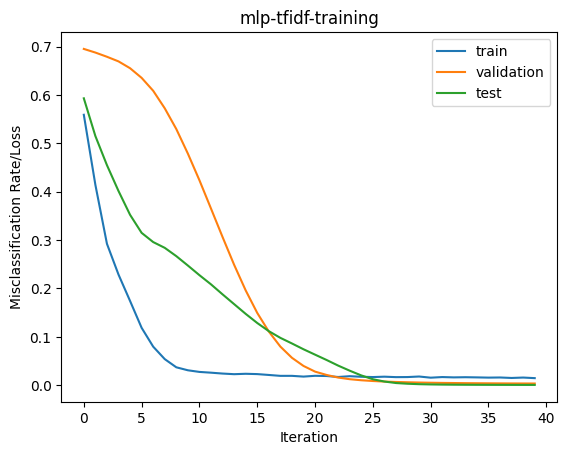

In [ ]:
classifier = MLPClassifier(hidden_layer_sizes=(150,100,50),
                           max_iter=40,activation = 'relu',
                           solver='adam',random_state=1).fit(X_train, y_train)

y_pred = classifier.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

classifier.fit(X_train,y_train); plt.plot(classifier.loss_curve_,label="train")
classifier.fit(X_valid,y_valid); plt.plot(classifier.loss_curve_,label="validation")
classifier.fit(X_test,y_test); plt.plot(classifier.loss_curve_,label="test")

plt.xlabel("Iteration")
plt.ylabel("Misclassification Rate/Loss");
plt.legend(loc='upper right')
plt.title('mlp-tfidf-training')
plt.show()

In [ ]:
sys.stdout =sys.__stdout__
print(sys.__stdout__, 'hello')

**Balanced Classification**

This experiments trains an ensemble of random forests on the balanced subsets

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


# Separate instances for class 1
class_1_instances = X_train_val[y_train_val == 1,:]
class_0_instances = X_train_val[y_train_val == 0,:]
num_classifiers = 15
classifiers = []
number_of_samples = class_1_instances.shape[0]
# Build an ensemble of classifiers (Random Forests in this example)

for ks in range(1,num_classifiers+1):
  # Randomly sample 2000 instances from class 0
  indices = np.random.choice(class_0_instances.shape[0], number_of_samples, replace=True)

  sampled_class_0_instances = class_0_instances[indices,:]

  # Combine instances for class 1 and sampled instances from class 0
  balanced_X = np.concatenate([class_1_instances, sampled_class_0_instances])
  balanced_y = np.concatenate([np.ones(class_1_instances.shape[0]), np.zeros(sampled_class_0_instances.shape[0])])

  classifier = RandomForestClassifier(n_estimators=1000, random_state=42)
  #classifier = sklearn.linear_model.LogisticRegression(random_state=42)
  classifier.fit(balanced_X, balanced_y)
  classifiers.append(classifier)
  y_pred = classifier.predict(X_test)
  print_results(y_test , y_pred,  current_options)

# Make predictions on the test set using each classifier
predictions = [classifier.predict(X_test) for classifier in classifiers]

# Take a majority vote to get the final ensemble prediction
ensemble_predictions = np.mean(predictions, axis=0) > 0.5

# Evaluate the ensemble performance
ensemble_accuracy = accuracy_score(y_test, ensemble_predictions)
print(f'Ensemble Accuracy: {ensemble_accuracy}')


**Longest Common Subsequence**

In [ ]:
def longest_common_subsequence(str1, str2):
    words1 = str1.split()
    words2 = str2.split()

    m = len(words1)
    n = len(words2)

    # Initializing the dp table with zeros
    dp = [[0] * (n + 1) for _ in range(m + 1)]

    # Building the dp table
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            if words1[i - 1] == words2[j - 1]:
                dp[i][j] = dp[i - 1][j - 1] + 1
            else:
                dp[i][j] = max(dp[i - 1][j], dp[i][j - 1])

    # Backtracking to find the longest common subsequence
    lcs_length = dp[m][n]
    lcs = []
    i = m
    j = n
    while i > 0 and j > 0:
        if words1[i - 1] == words2[j - 1]:
            lcs.append ( words1[i - 1])
            i -= 1
            j -= 1
            lcs_length -= 1
        elif dp[i - 1][j] > dp[i][j - 1]:
            i -= 1
        else:
            j -= 1

    lcs.reverse()
    return lcs , (2*len(lcs))/ (1+m+n) # 1 is denom is there to prevent div by 0
# Example usage:
str1        = "roses are red. violets are blue"
str2        = "the garden is full of roses and violets that are blue "
lcs12 , r12 = longest_common_subsequence(str1, str2)
print(f"Longest Common Subsequence:{r12}: {lcs12} ")


Longest Common Subsequence:0.4444444444444444: ['roses', 'violets', 'are', 'blue'] 


In [ ]:
import sys
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def remove_stopwords_list(tokens):
  filtered_tokens = [w for w in tokens if not w.lower() in stop_words]
  return filtered_tokens

def remove_stopwords_str(str):
  str = re.sub(r'[^A-Za-z0-9]+', ' ', str)
  str = re.sub(r'\W+', ' ', str)
  str = re.sub(r'\s+', ' ', str)

  tokens = str.split()
  filtered_tokens = [w for w in tokens if not w.lower() in stop_words]
  return ' '.join(filtered_tokens)

#--------------------
#

do_lcs = True # switch this flag if you want to run lcs

if do_lcs:
  train = train_df['sentence'].tolist(); train  = [remove_stopwords_str(s) for s in train ]
  test  = test_df['sentence'].tolist();  test   = [remove_stopwords_str(s) for s in test ]
  valid = valid_df['sentence'].tolist(); valid  = [remove_stopwords_str(s) for s in valid ]

  orig_stdout = sys.stdout;  f = open('out05.txt', 'w'); sys.stdout = f

  num_train = len(train); num_valid = len(valid); num_test  = len(test)
  for m in range(num_train):
    for n in range(num_valid):
      temp, r = longest_common_subsequence (train[m], valid[n])
      if r >= 0.1:
        print(f"({m}, {n})\t({y_train[m]}, {y_valid[n]}, ),\t{r:0.02f},\t{len(temp)},\t{temp}")
  #---
  sys.stdout = orig_stdout ;   f.close()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mmr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def remove_stopwords_str(str):
  re.sub(r'[^A-Za-z0-9]+', ' ', str)
  re.sub(r'\W+', ' ', str)
  re.sub(r'\s+', ' ', str)

s = train_df['sentence'][7]
print(s, remove_stopwords_str(s))


**A teste of ResNet**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

# Assuming X_train contains your text data and y_train contains the corresponding labels
num_classes = 2
# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train_val, dtype=torch.float32)
X_val_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_val, dtype=torch.long)
y_val_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Load pre-trained ResNet
resnet = models.resnet18(pretrained=True)

# Remove the fully connected layer
resnet = nn.Sequential(*list(resnet.children())[:-1])

# Freeze ResNet parameters
for param in resnet.parameters():
    param.requires_grad = False

# Define classifier on top of ResNet
classifier = nn.Sequential(
    nn.Linear(X_train_val.shape[0], 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, num_classes)  # num_classes is the number of classes in your classification task
)

# Combine ResNet and classifier
model = nn.Sequential(
    resnet,
    nn.Flatten(),
    classifier
)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10  # Adjust as needed
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    for inputs, labels in train_loader:
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    # Print average loss for each epoch
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

# Evaluation
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    outputs = model(X_val_tensor)
    _, predicted = torch.max(outputs, 1)
    accuracy = (predicted == y_val_tensor).sum().item() / len(y_val_tensor)
    print(f'Validation Accuracy: {accuracy:.4f}')


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_val_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)

# Define BiLSTM model
# Define BiLSTM model
class BiLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout):
        super(BiLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=1, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        output, _ = self.lstm(text)
        hidden = torch.cat((output[:, -1, :hidden_dim], output[:, 0, hidden_dim:]), dim=1)
        return self.fc(hidden)


# Define model parameters
input_dim = X_train_vec.shape[1]
embedding_dim = 100
hidden_dim = 128
output_dim = 2  # Assuming binary classification
dropout = 0.5

# Initialize model, loss function, and optimizer
model = BiLSTM(input_dim, hidden_dim, output_dim, dropout)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        print(type(inputs))
        outputs = model(inputs)
        print('OK2')
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

# Evaluation
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    outputs = model(X_val_tensor)
    _, predicted = torch.max(outputs, 1)
    accuracy = (predicted == y_val_tensor).sum().item() / len(y_val_tensor)
    print(f'Validation Accuracy: {accuracy:.4f}')


IndexError: tuple index out of range